# VarAnneal Tutorial

## Introduction
VarAnneal is a Python package for state and parameter estimation in partially observed dynamical systems and neural networks.  It uses variational annealing (VA), a variational data assimilation method.  VarAnneal is hosted on GitHub at [github.com/paulrozdeba/varanneal](http://github.com/paulrozdeba/varanneal).

In variational data assimilation, statistical path estimates conditioned on observational data are calculated using high-dimensional integrals of the form:
$$
\mathrm{E}\left[G(X) \lvert Y\right] = \frac{\int dX \: G(X)\: e^{-A(X,Y)}}{\int dX \: e^{-A(X,Y)}} \equiv \frac{1}{\mathcal{Z}(Y)} \int dX \: G(X)\: e^{-A(X,Y)}
$$
where $X$ is a vector of model states and parameters, and $Y$ is a vector of observational data.  These integrals may be approximated using Laplace's method around the dominant peaks of $P(X\lvert Y)$.  VA uses an annealing-like, numerical continuation method for finding these peaks using numerical optimization.  This optimization is carried out using one of a variety of methods, such as L-BFGS-B, NCG, IPOPT (future), ...   These methods require derivatives of $A$, which are computed with automatic differentiation (AD) using the PYADOLC wrapper around ADOL-C.

In dynamical systems, this amounts to estimating statistics for model parameters, as well as trajectories of model states, like the mode, mean, variance, ...  The data consists of time series of partial observations of the model variables.

In neural networks, this is used as a method of training the network weights on labeled data sets.

---

## Reusing Paul's sample code for a RNN

In [1]:
# Necessary package imports
import time
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
from varanneal import va_nnet

#### Define the activation function

In [3]:
def sigmoid(x, W, b):
    linpart = np.dot(W, x) + b
    return 1.0 / (1.0 + np.exp(-linpart))

#### Network structure

In [4]:
N = 3  # Total number of layers
D_in = 3  # Number of neurons in the input layer
D_out = 4  # Number of neurons in the output layer
D_hidden = 20  # Number of neurons in the hidden layers

# Network structure is stored in a list, where element i is the number 
# of neurons in layer i.
structure = np.zeros(N, dtype='int')
structure[0] = D_in  # 3 neurons in the input layer
structure[N-1] = D_out  # 2 neurons in the output layer
for i in range(1, N-1):
    structure[i] = D_hidden  # 5 neurons in the hidden layers

Lidx = [np.linspace(0, D_in-1, D_in, dtype='int'), np.linspace(0, D_out-1, D_out, dtype='int')]

#### Action/annealing parameters

In [5]:
# RM, RF0
RM = 1.0
RF0 = 1.0e-8 * RM * float(np.sum(structure) - structure[0]) / float(structure[0] + structure[-1])
g0 = RF0 / RM

# alpha, and beta ladder
alpha = 1.1
beta_array = np.linspace(0, 435, 436)
gammas_all = g0 * alpha**beta_array

#### Load data set (3 in, 4 out)

In [6]:
M = 290 # number of training examples
data = np.load('l96/data/l96_data_N5.npy') # has 5 l96 variables
data = data[0:300,:]
Didx = 0


T = data.shape[0]

data_in = np.zeros((M, D_in))
data_out = np.zeros((M, D_out))

for i in xrange(M):
    data_in[i] = data[i:i+D_in, Didx]
    data_out[i] = data[i+D_in:i+D_in+D_out, Didx]

#### Plot Data

<IPython.core.display.Javascript object>


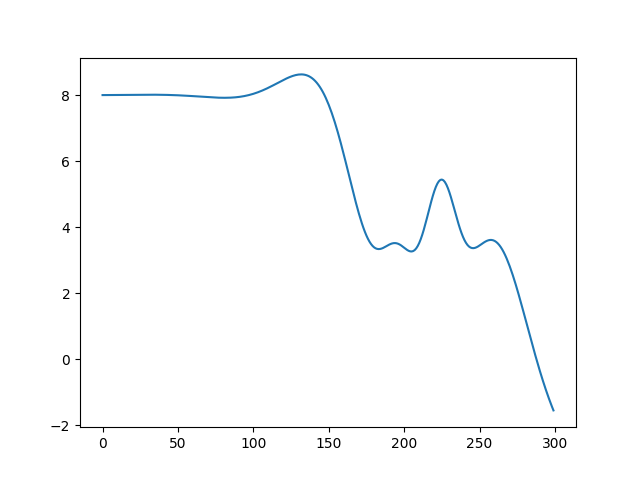

In [7]:
plt.plot(data[:,0])
plt.show()

#### Initial neuron activation/weight guesses

In [8]:
np.random.seed(27509436)

# Neuron states
Xin = np.random.randn(D_in)
Xin = (Xin - np.average(Xin)) / np.std(Xin)
X0 = np.copy(Xin)

for n in xrange(N-2):
    X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

for m in xrange(M - 1):
    Xin = np.random.randn(D_in)
    Xin = (Xin - np.average(Xin)) / np.std(Xin)
    X0 = np.append(X0, Xin)
    for n in xrange(N-2):
        X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
    X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

X0 = np.array(X0).flatten()

# Parameters
NP = np.sum(structure[1:]*structure[:-1] + structure[1:])
P0 = np.array([], dtype=np.float64)

W_i0 = 0
W_if = structure[0]*structure[1]
b_i0 = W_if
b_if = b_i0 + structure[1]

# Set up Pidx so that only weights, not biases, are estimated
for n in xrange(N - 1):
    if n == 0:
        Pidx = np.arange(W_i0, W_if, 1, dtype='int')
    else:
        Pidx = np.append(Pidx, np.arange(W_i0, W_if, 1, dtype='int'))
    if n == 0:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_in)
    else:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_hidden)
    P0 = np.append(P0, np.zeros(structure[n+1]))

    if n < N - 2:
        W_i0 = b_if
        W_if = W_i0 + structure[n+1]*structure[n+2]
        b_i0 = W_if
        b_if = b_i0 + structure[n+2]

P0 = np.array(P0).flatten()
Pidx = np.array(Pidx).flatten().tolist()

### Use VA to train the network weights

In [9]:
# Initialize Annealer
anneal1 = va_nnet.Annealer()
# Set the network structure
anneal1.set_structure(structure)
# Set the activation function
anneal1.set_activation(sigmoid)
# Set the input and output data
anneal1.set_input_data(data_in)
anneal1.set_output_data(data_out)

#### Run VA using L-BFGS-B

In [10]:
BFGS_options = {'gtol':1.0e-12, 'ftol':1.0e-12, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()
anneal1.anneal(X0, P0, alpha, beta_array, RM, RF0, Pidx, Lidx=Lidx,
               method='L-BFGS-B', opt_args=BFGS_options, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

------------------------------
Step 1 of 436
beta = 0, RF = 3.42857143e-08

Taping action evaluation...
Done!
Time = 0.371177911758 s

Beginning optimization...
Optimization complete!
Time = 0.152948856354 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 16
Obj. function value = [  1.76041258e-07]

------------------------------
Step 2 of 436
beta = 1, RF = 3.77142857e-08

Taping action evaluation...
Done!
Time = 0.846820831299 s

Beginning optimization...
Optimization complete!
Time = 0.0321440696716 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  1.93645343e-07]

------------------------------
Step 3 of 436
beta = 2, RF = 4.14857143e-08

Taping action evaluation...
Done!
Time = 0.433046102524 s

Beginning optimization...
Optimization complete!
Time = 0.0380289554596 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function va

Done!
Time = 0.359973907471 s

Beginning optimization...
Optimization complete!
Time = 0.0328950881958 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  1.71505460e-06]

------------------------------
Step 26 of 436
beta = 25, RF = 3.71475632e-07

Taping action evaluation...
Done!
Time = 0.403694152832 s

Beginning optimization...
Optimization complete!
Time = 0.0744218826294 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  1.88655943e-06]

------------------------------
Step 27 of 436
beta = 26, RF = 4.08623196e-07

Taping action evaluation...
Done!
Time = 0.326731920242 s

Beginning optimization...
Optimization complete!
Time = 0.0361618995667 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  2.07521463e-06]

------------------------------
Step 28 of 436
beta = 27, RF = 4.49485515e-

Done!
Time = 0.446520805359 s

Beginning optimization...
Optimization complete!
Time = 0.0335230827332 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  1.68074284e-05]

------------------------------
Step 50 of 436
beta = 49, RF = 3.65893567e-06

Taping action evaluation...
Done!
Time = 0.448652029037 s

Beginning optimization...
Optimization complete!
Time = 0.0388979911804 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  1.84881695e-05]

------------------------------
Step 51 of 436
beta = 50, RF = 4.02482924e-06

Taping action evaluation...
Done!
Time = 0.451902866364 s

Beginning optimization...
Optimization complete!
Time = 0.0371799468994 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  2.03369842e-05]

------------------------------
Step 52 of 436
beta = 51, RF = 4.42731217e-

beta = 72, RF = 3.27632166e-05

Taping action evaluation...
Done!
Time = 0.409784078598 s

Beginning optimization...
Optimization complete!
Time = 0.0497040748596 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00016555]

------------------------------
Step 74 of 436
beta = 73, RF = 3.60395383e-05

Taping action evaluation...
Done!
Time = 0.316405057907 s

Beginning optimization...
Optimization complete!
Time = 0.0707859992981 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.0001821]

------------------------------
Step 75 of 436
beta = 74, RF = 3.96434921e-05

Taping action evaluation...
Done!
Time = 0.316277980804 s

Beginning optimization...
Optimization complete!
Time = 0.0472068786621 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00020031]

------------------------------

beta = 97, RF = 3.54979818e-04

Taping action evaluation...
Done!
Time = 0.327718019485 s

Beginning optimization...
Optimization complete!
Time = 0.0399549007416 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00179348]

------------------------------
Step 99 of 436
beta = 98, RF = 3.90477799e-04

Taping action evaluation...
Done!
Time = 0.28248500824 s

Beginning optimization...
Optimization complete!
Time = 0.0348420143127 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00197281]

------------------------------
Step 100 of 436
beta = 99, RF = 4.29525579e-04

Taping action evaluation...
Done!
Time = 0.309836864471 s

Beginning optimization...
Optimization complete!
Time = 0.0437040328979 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00217006]

-----------------------------


Taping action evaluation...
Done!
Time = 0.344874858856 s

Beginning optimization...
Optimization complete!
Time = 0.0465140342712 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.01764912]

------------------------------
Step 123 of 436
beta = 122, RF = 3.84610194e-03

Taping action evaluation...
Done!
Time = 0.338412046432 s

Beginning optimization...
Optimization complete!
Time = 0.0541989803314 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.01941205]

------------------------------
Step 124 of 436
beta = 123, RF = 4.23071213e-03

Taping action evaluation...
Done!
Time = 0.300621986389 s

Beginning optimization...
Optimization complete!
Time = 0.0373799800873 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.02135086]

------------------------------
Step 125 of 436
beta = 12


Taping action evaluation...
Done!
Time = 0.323064088821 s

Beginning optimization...
Optimization complete!
Time = 0.0460798740387 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.18932608]

------------------------------
Step 148 of 436
beta = 147, RF = 4.16713836e-02

Taping action evaluation...
Done!
Time = 0.408310890198 s

Beginning optimization...
Optimization complete!
Time = 0.039204120636 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.20803134]

------------------------------
Step 149 of 436
beta = 148, RF = 4.58385219e-02

Taping action evaluation...
Done!
Time = 0.379137039185 s

Beginning optimization...
Optimization complete!
Time = 0.0434448719025 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.22856001]

------------------------------
Step 150 of 436
beta = 149

Done!
Time = 0.286216020584 s

Beginning optimization...
Optimization complete!
Time = 0.0441060066223 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 1.70036222]

------------------------------
Step 172 of 436
beta = 171, RF = 4.10451988e-01

Taping action evaluation...
Done!
Time = 0.284795045853 s

Beginning optimization...
Optimization complete!
Time = 0.0852589607239 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 1.8522189]

------------------------------
Step 173 of 436
beta = 172, RF = 4.51497187e-01

Taping action evaluation...
Done!
Time = 0.308135032654 s

Beginning optimization...
Optimization complete!
Time = 0.0493440628052 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 2.01588778]

------------------------------
Step 174 of 436
beta = 173, RF = 4.96646906e-01

Taping

Taping action evaluation...
Done!
Time = 0.321423053741 s

Beginning optimization...
Optimization complete!
Time = 0.0523290634155 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 9.37421104]

------------------------------
Step 197 of 436
beta = 196, RF = 4.44712660e+00

Taping action evaluation...
Done!
Time = 0.35658121109 s

Beginning optimization...
Optimization complete!
Time = 0.0822100639343 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 9.78230378]

------------------------------
Step 198 of 436
beta = 197, RF = 4.89183926e+00

Taping action evaluation...
Done!
Time = 0.353084087372 s

Beginning optimization...
Optimization complete!
Time = 0.0551331043243 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 10.1854008]

------------------------------
Step 199 of 436
beta = 198,

Done!
Time = 0.314465045929 s

Beginning optimization...
Optimization complete!
Time = 0.065896987915 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 15.95074565]

------------------------------
Step 221 of 436
beta = 220, RF = 4.38030082e+01

Taping action evaluation...
Done!
Time = 0.319092035294 s

Beginning optimization...
Optimization complete!
Time = 0.0523369312286 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 16.06653317]

------------------------------
Step 222 of 436
beta = 221, RF = 4.81833090e+01

Taping action evaluation...
Done!
Time = 0.350411891937 s

Beginning optimization...
Optimization complete!
Time = 0.0480849742889 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 16.17326297]

------------------------------
Step 223 of 436
beta = 222, RF = 5.30016399e+01

Tap

Done!
Time = 0.319221973419 s

Beginning optimization...
Optimization complete!
Time = 0.0421900749207 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.18751764]

------------------------------
Step 246 of 436
beta = 245, RF = 4.74592713e+02

Taping action evaluation...
Done!
Time = 0.325985908508 s

Beginning optimization...
Optimization complete!
Time = 0.0443720817566 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.19984526]

------------------------------
Step 247 of 436
beta = 246, RF = 5.22051984e+02

Taping action evaluation...
Done!
Time = 0.371653079987 s

Beginning optimization...
Optimization complete!
Time = 0.0406467914581 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.21106754]

------------------------------
Step 248 of 436
beta = 247, RF = 5.74257182e+02

Ta

Done!
Time = 0.327833890915 s

Beginning optimization...
Optimization complete!
Time = 0.0375361442566 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.31140409]

------------------------------
Step 271 of 436
beta = 270, RF = 5.14207249e+03

Taping action evaluation...
Done!
Time = 0.314310789108 s

Beginning optimization...
Optimization complete!
Time = 0.0413949489594 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.31255759]

------------------------------
Step 272 of 436
beta = 271, RF = 5.65627973e+03

Taping action evaluation...
Done!
Time = 0.367290019989 s

Beginning optimization...
Optimization complete!
Time = 0.0394129753113 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.31360636]

------------------------------
Step 273 of 436
beta = 272, RF = 6.22190771e+03

Ta

Done!
Time = 0.324956893921 s

Beginning optimization...
Optimization complete!
Time = 0.0374848842621 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.3229284]

------------------------------
Step 296 of 436
beta = 295, RF = 5.57128433e+04

Taping action evaluation...
Done!
Time = 0.30681180954 s

Beginning optimization...
Optimization complete!
Time = 0.0493268966675 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.323035]

------------------------------
Step 297 of 436
beta = 296, RF = 6.12841277e+04

Taping action evaluation...
Done!
Time = 0.351737976074 s

Beginning optimization...
Optimization complete!
Time = 0.0411150455475 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.32313191]

------------------------------
Step 298 of 436
beta = 297, RF = 6.74125404e+04

Taping

Taping action evaluation...
Done!
Time = 0.324339151382 s

Beginning optimization...
Optimization complete!
Time = 0.042552947998 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.32399282]

------------------------------
Step 321 of 436
beta = 320, RF = 6.03632275e+05

Taping action evaluation...
Done!
Time = 0.314583778381 s

Beginning optimization...
Optimization complete!
Time = 0.0496108531952 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 17.32400266]

------------------------------
Step 322 of 436
beta = 321, RF = 6.63995502e+05

Taping action evaluation...
Done!
Time = 0.354634046555 s

Beginning optimization...
Optimization complete!
Time = 0.0438129901886 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.3240116]

------------------------------
Step 323 of 436
beta = 32

Done!
Time = 0.33858704567 s

Beginning optimization...
Optimization complete!
Time = 0.0937860012054 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.32409007]

------------------------------
Step 345 of 436
beta = 344, RF = 5.94561654e+06

Taping action evaluation...
Done!
Time = 0.306951999664 s

Beginning optimization...
Optimization complete!
Time = 0.0455861091614 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.32409107]

------------------------------
Step 346 of 436
beta = 345, RF = 6.54017819e+06

Taping action evaluation...
Done!
Time = 0.302717924118 s

Beginning optimization...
Optimization complete!
Time = 0.0486898422241 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.32409198]

------------------------------
Step 347 of 436
beta = 346, RF = 7.19419601e+06

Tap

Done!
Time = 0.337486982346 s

Beginning optimization...
Optimization complete!
Time = 0.111167907715 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.32409994]

------------------------------
Step 369 of 436
beta = 368, RF = 5.85627335e+07

Taping action evaluation...
Done!
Time = 0.301645994186 s

Beginning optimization...
Optimization complete!
Time = 0.0431799888611 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 17.32410004]

------------------------------
Step 370 of 436
beta = 369, RF = 6.44190069e+07

Taping action evaluation...
Done!
Time = 0.361618041992 s

Beginning optimization...
Optimization complete!
Time = 0.0501668453217 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 17.32410014]

------------------------------
Step 371 of 436
beta = 370, RF = 7.08609075e+07

Tap

Done!
Time = 0.326964139938 s

Beginning optimization...
Optimization complete!
Time = 0.0318031311035 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 17.32410095]

------------------------------
Step 393 of 436
beta = 392, RF = 5.76827270e+08

Taping action evaluation...
Done!
Time = 0.330211162567 s

Beginning optimization...
Optimization complete!
Time = 0.0751008987427 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 17.32410096]

------------------------------
Step 394 of 436
beta = 393, RF = 6.34509997e+08

Taping action evaluation...
Done!
Time = 0.327568054199 s

Beginning optimization...
Optimization complete!
Time = 0.0669300556183 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 17.32410096]

------------------------------
Step 395 of 436
beta = 394, RF = 6.97960997e+08

Ta


Taping action evaluation...
Done!
Time = 0.33266210556 s

Beginning optimization...
Optimization complete!
Time = 0.0338740348816 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 17.32410105]

------------------------------
Step 418 of 436
beta = 417, RF = 6.24975385e+09

Taping action evaluation...
Done!
Time = 0.438231945038 s

Beginning optimization...
Optimization complete!
Time = 0.0286149978638 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 17.32410105]

------------------------------
Step 419 of 436
beta = 418, RF = 6.87472923e+09

Taping action evaluation...
Done!
Time = 0.367774009705 s

Beginning optimization...
Optimization complete!
Time = 0.0411219596863 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 17.32410105]

------------------------------
Step 420 of 436
beta = 

#### Save the output

In [11]:
anneal1.save_io("l96/results/io.npy")
anneal1.save_Wb("l96/results/W.npy", "l96/results/b.npy")
anneal1.save_action_errors("l96/results/action_errors.npy")

### Plot the results

In [12]:
# Load action curves
aerr = np.load("l96/results/action_errors.npy")

<IPython.core.display.Javascript object>


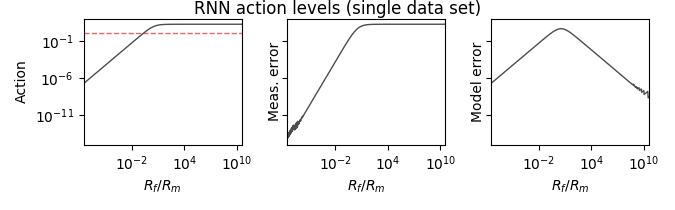

In [13]:
fig,ax = plt.subplots(1, 3, figsize=(6.75, 2.1), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = .7
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$R_f/R_m$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3", alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$R_f/R_m$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$R_f/R_m$")
ax[2].set_ylabel("Model error")

fig.suptitle("RNN action levels (single data set)", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(gammas_all[0], gammas_all[-1])
    #ax[i].set_ylim(.001, 1.0e2)

plt.show()

#### Parameter estimates

In [11]:
#structure = np.array([25, 3, 4])
Nbias = np.sum(structure[1:])
Nweight = np.sum(structure[1:] * structure[:-1])

sortedp = []

West = np.load("l96/results/W.npy")
best = np.load("l96/results/b.npy")

for i in xrange(len(gammas_all)):
    #West = np.load("W.npy")
    #best = np.load("b.npy")
    for j, West_n in enumerate(West[i]):
        if j == 0:
            pest = West_n.flatten()#, best_n.flatten())
        else:
            pest = np.append(pest, West_n.flatten())
    for j, best_n in enumerate(best[i]):
        pest = np.append(pest, best_n.flatten())
    sortedp.append(pest.flatten())

sortedp = np.array(sortedp)

In [12]:
fig,ax = plt.subplots(1, 1, figsize=(5,4))
fig.set_tight_layout(True)

nrange = range(Nweight + Nbias)
surf = ax.pcolormesh(gammas_all, nrange, np.abs(sortedp.T), rasterized=True, cmap='jet', norm=mplcolors.LogNorm())#, vmin=1.0E-7, vmax=1.0E3)
#surf = ax.pcolormesh(g, nrange, sortedp.T, rasterized=True, cmap='jet')#, norm=mplcolors.LogNorm())
ax.set_xscale("log")
ax.set_xlabel(r"$R_f/R_m$")
ax.set_ylabel(r"Parameter metaindex")
cbar = fig.colorbar(surf, ax=ax)
cbar.set_label(r"$W$")
ax.set_xlim((gammas_all[0], gammas_all[-1]))
ax.set_ylim((nrange[0], nrange[-1]))
#ax.set_title("Est. err. vs. data, sec%d mem%d"%(secID, ensID))

plt.show()
#fig.savefig("/home/prozdeba/Desktop/plots_20170801/nnet/params_M%d.pdf"%(Ntraining,))
#plt.close()

<IPython.core.display.Javascript object>

NameError: name 'mplcolors' is not defined

### Generate Some Plots